# Data Maps

This notebook is a guide through the process of creating a **data map** based on training dynamics, as described in the paper [*Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics*](https://aclanthology.org/2020.emnlp-main.746). The goal is to compute confidence, variability, and correctness for each training instance, then visualize them in a 2D scatter plot.

In data maps, the three key concepts used to characterize each training example are **confidence** and **variability** and **correctness**. These concepts are used together to visualize and categorize training data points into *easy*, *ambiguous*, and *hard* regions of a 2D space (e.g., confidence vs variability), helping with tasks like data pruning, curriculum learning, and error analysis.

---

## 1. **Confidence**

> **Definition**: The *average* predicted probability that the model assigns to the gold (true) label across multiple training epochs.

* **Interpretation**:

  * High confidence ⇒ the model *usually* predicts the correct class with high certainty.
  * Low confidence ⇒ the model is often unsure about the correct class.
* **Use**: Helps distinguish *easy* vs *ambiguous* examples.

---

## 2. **Variability**

> **Definition**: The standard deviation (or variance) of the model’s predicted probability for the gold label across epochs.

* **Interpretation**:

  * High variability ⇒ the model is *inconsistent* in how confidently it classifies the example over time (e.g., influenced by learning dynamics, randomness, or proximity to decision boundary).
  * Low variability ⇒ the model has *stable behavior* toward the example.
* **Use**: Detects *unstable* or *contentious* examples.

---

## 3. **Correctness**

> **Definition**: The fraction of training epochs during which the model correctly predicts the gold label.

* **Interpretation**:

  * Close to 1 ⇒ the model almost always gets it right
  * Close to 0 ⇒ the model rarely or never gets it right
* **Use**: Helps identify *hard* examples (often misclassified), as opposed to *easy* or *learnable* ones.

---

## Summary Table

| Concept         | Measures                               | High Value Means...                      | Low Value Means...          |
| --------------- | -------------------------------------- | ---------------------------------------- | --------------------------- |
| **Confidence**  | Avg. prob. on correct label            | Model is sure about this example         | Model is uncertain about it |
| **Variability** | Std. dev. of prob. across epochs       | Inconsistent predictions (unstable)      | Stable predictions          |
| **Correctness** | Fraction of epochs predicted correctly | Example is reliably classified correctly | Often misclassified         |


**Note:** Data maps assume access to training dynamics (per-epoch predicted probabilities) that are typical of models trained using gradient-based methods (neural networks, logistic regression, etc.); for non-gradient-based methods, these curves may not be available in the same way.



# Toy Example

This section presents toy example that illustrates how to compute confidence, variability, and correctness for a few training instances over multiple training epochs.

Assume you have a classification model trained for 5 epochs. For 3 training examples (`x1`, `x2`, `x3`), you record the predicted probability assigned to the correct class at each epoch:

```python
# Probabilities assigned to the correct label at each epoch
probs = {
    "x1": [0.95, 0.96, 0.94, 0.97, 0.95],  # high and stable
    "x2": [0.60, 0.20, 0.90, 0.40, 0.70],  # jumpy
    "x3": [0.10, 0.20, 0.05, 0.15, 0.08],  # always low
}

# Predicted class at each epoch
preds = {
    "x1": [1, 1, 1, 1, 1],  # always correct
    "x2": [1, 0, 1, 0, 1],  # alternates
    "x3": [0, 0, 0, 0, 0],  # always wrong
}

# True class
gold = {
    "x1": 1,
    "x2": 1,
    "x3": 1,
}
```

---

Given the results above, here is how to compute the metrics:

```python
import numpy as np

def compute_data_map_metrics(probs, preds, gold):
    data_map = []
    for x_id in probs:
        prob_true_label = np.array(probs[x_id])
        pred_seq = np.array(preds[x_id])
        true_label = gold[x_id]

        confidence = prob_true_label.mean()
        variability = prob_true_label.std()
        correctness = np.mean(pred_seq == true_label)

        data_map.append({
            "example": x_id,
            "confidence": confidence,
            "variability": variability,
            "correctness": correctness
        })
    return data_map

results = compute_data_map_metrics(probs, preds, gold)
for row in results:
    print(row)
```

---

### Output

```python
{'example': 'x1', 'confidence': 0.954, 'variability': 0.010198, 'correctness': 1.0}
{'example': 'x2', 'confidence': 0.56,  'variability': 0.244,    'correctness': 0.6}
{'example': 'x3', 'confidence': 0.116, 'variability': 0.056,    'correctness': 0.0}
```

---

## Interpretation

| Example | Confidence | Variability | Correctness | Type              |
| ------- | ---------- | ----------- | ----------- | ----------------- |
| x1      | High       | Low         | 1.0         | **Easy**          |
| x2      | Medium     | High        | 0.6         | **Ambiguous**     |
| x3      | Low        | Low         | 0.0         | **Hard-to-learn** |



The code below produces the **data map** for the toy example.

* **x-axis = confidence** (average probability assigned to the correct label)
* **y-axis = variability** (standard deviation of that probability over epochs)
* **Color = correctness** (green = more frequently correct)

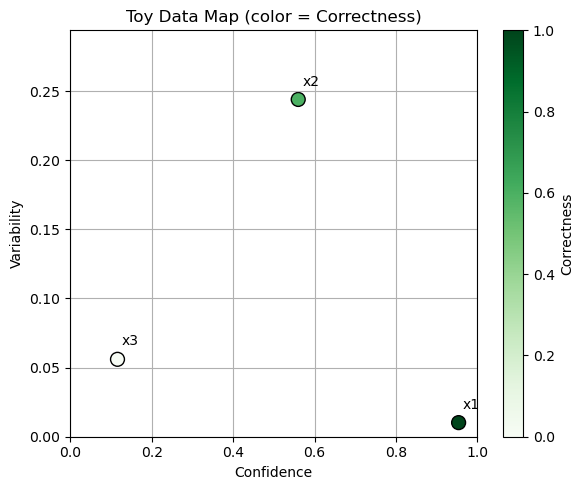

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Toy example metrics
examples = ["x1", "x2", "x3"]
confidence = [0.954, 0.56, 0.116]
variability = [0.010198, 0.244, 0.056]
correctness = [1.0, 0.6, 0.0]

# Color map for correctness (greener = more correct)
colors = plt.cm.Greens(correctness)

# Create scatter plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(confidence, variability, c=correctness, cmap='Greens', s=100, edgecolor='black')

# Annotate points
for i, txt in enumerate(examples):
    plt.annotate(txt, (confidence[i] + 0.01, variability[i] + 0.01))

# Labels and styling
plt.xlabel("Confidence")
plt.ylabel("Variability")
plt.title("Toy Data Map (color = Correctness)")
cbar = plt.colorbar(scatter, label="Correctness")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, max(variability) + 0.05)
plt.tight_layout()
plt.show()


**Interpretation:**

* **x1**: High confidence, low variability, correctness = 1.0 ⇒ Easy
* **x2**: Medium confidence, high variability, correctness ≈ 0.6 ⇒ Ambiguous
* **x3**: Low confidence, low variability, correctness = 0.0 ⇒ Hard-to-learn

---

# Example Code

## Step 1: Load the Adult Dataset

In [40]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


## Step 2: Preprocess the Dataset

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Clean placeholders for missing values and drop incomplete rows
df = df.replace('?', pd.NA).dropna()

# Split features and labels
X = df.drop('class', axis=1)
y = df['class']

categorical_cols = X.select_dtypes(include='category').columns
numeric_cols = X.columns.difference(categorical_cols)

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit/transform features
X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

# Encode labels only
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


## Step 3: Train Model and Capture Training Dynamics

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Convert to dense arrays for PyTorch
X_train_array = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# Simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)
n_classes = len(np.unique(y_train))
model = SimpleNN(X_tensor.shape[1], n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Track training dynamics
EPOCHS = 10
prob_history = np.zeros((len(X_train_array), EPOCHS, n_classes), dtype=np.float32)
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in dataloader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_tensor), dim=1).cpu().numpy()
        prob_history[:, epoch, :] = probs


## Step 4: Compute Confidence and Variability

In [44]:
true_label_probs = prob_history[np.arange(len(y_train)), :, y_train]
confidence = true_label_probs.mean(axis=1)
variability = true_label_probs.std(axis=1)


## Step 4.1: Compute Correctness

In [45]:
# Correctness: fraction of epochs where the predicted class matches the true label
predicted_labels = prob_history.argmax(axis=2)
correctness = (predicted_labels == y_train[:, None]).mean(axis=1)


## Step 5: Plot the Data Map

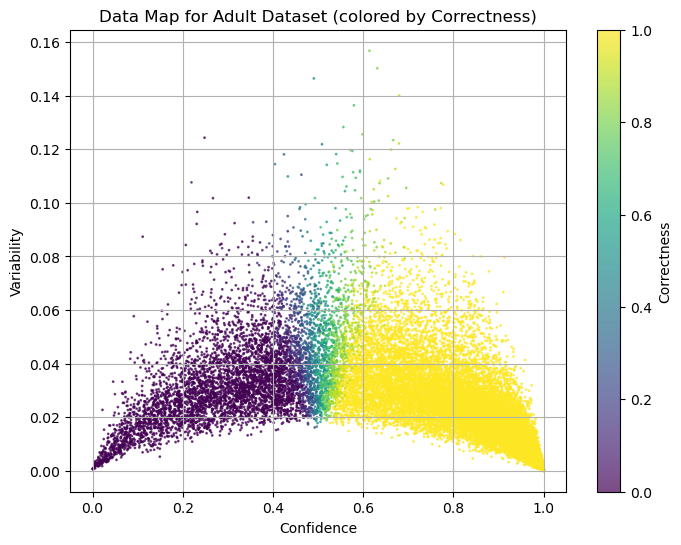

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(confidence, variability, c=correctness, cmap='viridis', alpha=0.7, s=1)
plt.xlabel('Confidence')
plt.ylabel('Variability')
plt.title('Data Map for Adult Dataset (colored by Correctness)')
cbar = plt.colorbar(scatter, label='Correctness')
plt.grid(True)
plt.show()


## Step 5.1: Interpreting the Data Map Regions

The data map provides insights into different types of training examples:

- **Easy-to-learn**: Instances with high confidence and low variability. These are consistently predicted correctly early in training.
- **Ambiguous**: Instances with high variability. The model's predictions fluctuate during training, indicating uncertainty.
- **Hard-to-learn**: Instances with low confidence and low variability. These are consistently predicted incorrectly, possibly due to label noise or inherent difficulty.

The color scale in the plot corresponds to **correctness**, i.e., how frequently the model predicted the correct label across epochs.


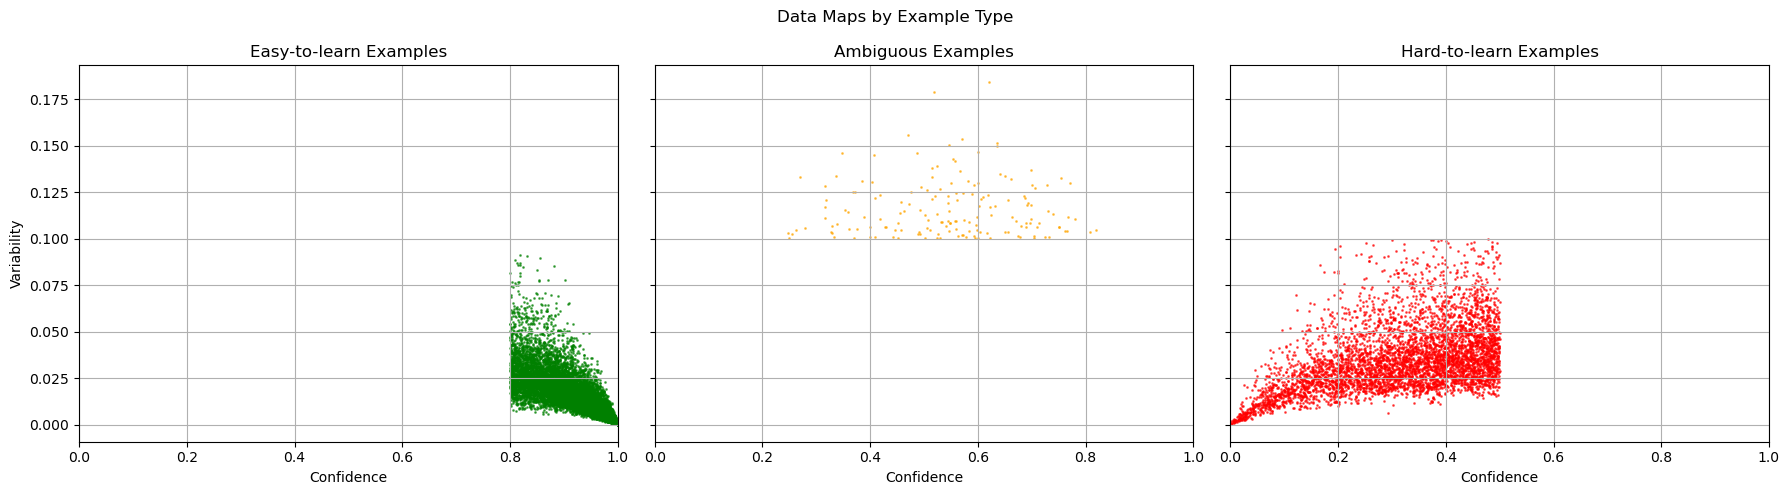

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess Adult dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean missing values ("?" placeholders)
df = df.replace('?', pd.NA).dropna()

# Separate features/labels
X = df.drop(columns='class')
y = df['class']

categorical_cols = X.select_dtypes(include='category').columns
numeric_cols = X.columns.difference(categorical_cols)

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = preprocess.fit_transform(X_train)
X_train_array = X_train.toarray() if hasattr(X_train, 'toarray') else X_train

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Prepare PyTorch datasets
X_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

n_classes = len(np.unique(y_train))
model = SimpleNN(X_tensor.shape[1], n_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train and record training dynamics
EPOCHS = 10
prob_history = np.zeros((len(X_tensor), EPOCHS, n_classes), dtype=np.float32)

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in dataloader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_tensor), dim=1).numpy()
        prob_history[:, epoch, :] = probs

# Compute metrics
true_label_probs = prob_history[np.arange(len(y_train)), :, y_train]
confidence = true_label_probs.mean(axis=1)
variability = true_label_probs.std(axis=1)
predicted_labels = prob_history.argmax(axis=2)
correctness = (predicted_labels == y_train[:, None]).mean(axis=1)

# Masks for different types
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)
ambiguous_mask = (variability >= 0.1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].scatter(confidence[easy_mask], variability[easy_mask], c='green', alpha=0.6, s=1)
axes[0].set_title('Easy-to-learn Examples')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Variability')
axes[0].grid(True)
axes[0].set_xlim(0, 1)

axes[1].scatter(confidence[ambiguous_mask], variability[ambiguous_mask], c='orange', alpha=0.6, s=1)
axes[1].set_title('Ambiguous Examples')
axes[1].set_xlabel('Confidence')
axes[1].grid(True)
axes[1].set_xlim(0, 1)

axes[2].scatter(confidence[hard_mask], variability[hard_mask], c='red', alpha=0.6, s=1)
axes[2].set_title('Hard-to-learn Examples')
axes[2].set_xlabel('Confidence')
axes[2].grid(True)
axes[2].set_xlim(0, 1)

plt.suptitle('Data Maps by Example Type')
plt.tight_layout()
plt.show()


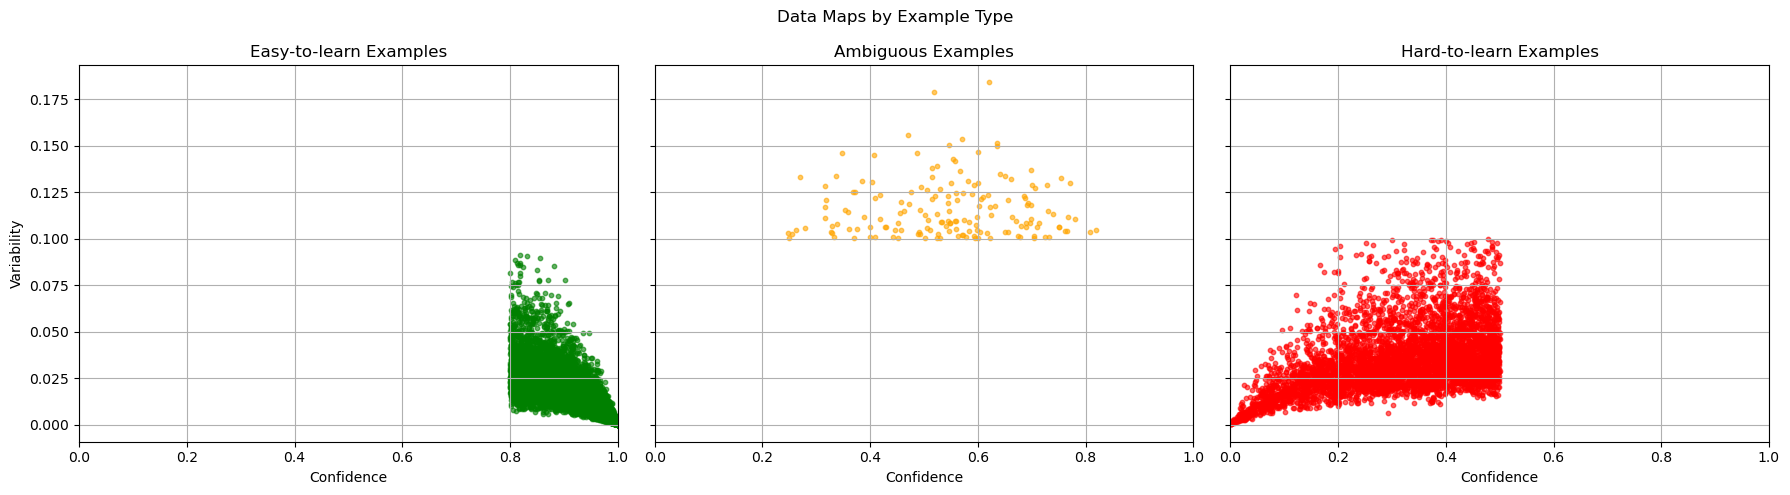

In [48]:
# Masks for different types
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)
ambiguous_mask = (variability >= 0.1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].scatter(confidence[easy_mask], variability[easy_mask], c='green', alpha=0.6, s=10)
axes[0].set_title('Easy-to-learn Examples')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Variability')
axes[0].set_xlim(0, 1)
axes[0].grid(True)

axes[1].scatter(confidence[ambiguous_mask], variability[ambiguous_mask], c='orange', alpha=0.6, s=10)
axes[1].set_title('Ambiguous Examples')
axes[1].set_xlabel('Confidence')
axes[1].set_xlim(0, 1)
axes[1].grid(True)

axes[2].scatter(confidence[hard_mask], variability[hard_mask], c='red', alpha=0.6, s=10)
axes[2].set_title('Hard-to-learn Examples')
axes[2].set_xlabel('Confidence')
axes[2].set_xlim(0, 1)
axes[2].grid(True)

plt.suptitle('Data Maps by Example Type')
plt.tight_layout()
plt.show()


## Class Distribution by Data Map Region (proportions)

The purpose of the code below is to analyze how the class distribution varies across different regions of a data map for the Adult dataset. It helps in understanding whether certain types of examples (e.g., >50K) tend to be harder, easier, or more ambiguous for the model to learn.

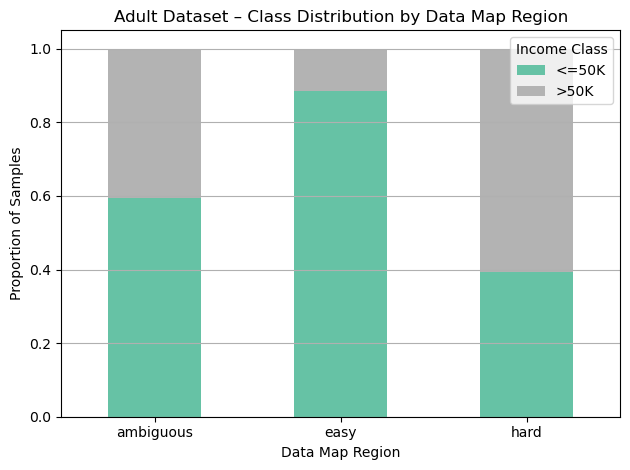

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define regions in the data map
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)

# Default all points to ambiguous; override easy/hard where applicable
df_map = pd.DataFrame({
    "confidence": confidence,
    "variability": variability,
    "class": y_train,
    "region": "ambiguous"
})
df_map.loc[easy_mask, "region"] = "easy"
df_map.loc[hard_mask, "region"] = "hard"

# Count and normalize class distribution in each region
region_class_counts = df_map.groupby(["region", "class"]).size().unstack(fill_value=0)
region_class_percent = region_class_counts.div(region_class_counts.sum(axis=1), axis=0)

# Plot normalized class distribution
region_class_percent.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Adult Dataset – Class Distribution by Data Map Region")
plt.xlabel("Data Map Region")
plt.ylabel("Proportion of Samples")
plt.xticks(rotation=0)
plt.legend(title="Income Class", labels=["<=50K", ">50K"])
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Each bar corresponds to a region of the data map:

* **Easy**: high confidence, low variability
* **Hard**: low confidence, low variability
* **Ambiguous**: variability above the threshold (model fluctuates over epochs)

Each bar is stacked by income class:

* **Green** = `<=50K`
* **Gray** = `>50K`

### Interpretation

**Easy**
- Majority class (`<=50K`) dominates
- The model is very confident and consistent when predicting `<=50K` examples
- Very few `>50K` examples are "easy" for the model

**Hard**
- The situation flips: `>50K` makes up the majority
- These are the examples the model **frequently gets wrong but still does so consistently**
- Suggests that the model **struggles to learn from `>50K` examples**, possibly due to class imbalance or inherent ambiguity

**Ambiguous**
- Model confidence is less stable across epochs
- Mix of both classes with higher variability, indicating borderline or unstable examples

## What this tells about the data?

* The model learns `<=50K` examples more easily. Unsurprising, as this is typically the majority class.
* The `>50K` class tends to be harder, even in cases where the model is confident; a sign of systematic bias or lack of discriminative features.
* This supports data-centric interventions, such as:
  * Reweighting or upsampling `>50K`
  * Prioritizing `>50K` hard/ambiguous examples for augmentation or review
  * Using data maps to guide curriculum learning


## Class Distribution by Data Map Region (absolute values)

This version complements the previous proportional view by showing the absolute sample sizes.

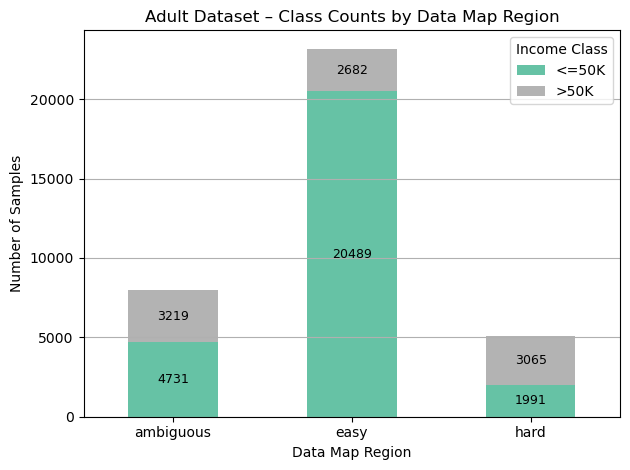

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define regions in the data map
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)

# Default all points to ambiguous; override easy/hard where applicable
df_map = pd.DataFrame({
    "confidence": confidence,
    "variability": variability,
    "class": y_train,
    "region": "ambiguous"
})
df_map.loc[easy_mask, "region"] = "easy"
df_map.loc[hard_mask, "region"] = "hard"

# Contagem absoluta de exemplos por classe e região
region_class_counts = df_map.groupby(["region", "class"]).size().unstack(fill_value=0)

# Plotagem com anotações de valores
ax = region_class_counts.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Adult Dataset – Class Counts by Data Map Region")
plt.xlabel("Data Map Region")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.legend(title="Income Class", labels=["<=50K", ">50K"])
plt.grid(axis="y")

# Adiciona rótulos com contagens nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}", 
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha="center", va="center", fontsize=9, color="black")

plt.tight_layout()
plt.show()


The purpose of this plot is to **visualize the absolute number of training examples** in the **Adult dataset**, broken down by:

1. **Data map region** (easy, hard, ambiguous, other)
2. **Class label** (income: `<=50K` or `>50K`)

---

## What the Plot Shows

* It’s a **stacked bar chart** where:

  * **Each bar** represents a region on the data map (`easy`, `hard`, `ambiguous`, `other`).
  * **Bar segments** correspond to the number of examples in each **income class**.
  * **Numeric annotations** on the bars show the exact count of samples per class in each region.

1. **Quantify sample imbalance per region**

* We can see:
  * "How many `>50K` examples are hard"
  * "How many `<=50K` examples are in the easy region"

2. **Assess data sufficiency**

* A region with very few examples (e.g., `hard & >50K`) might be:

  * **Underrepresented** → possibly hurting generalization.
  * **Candidate for augmentation**, reweighting, or review.

3. **Support decisions about selective training**

* For example, if most ambiguous examples are from `>50K`, you might:

  * Focus on **hard `>50K`** to reduce model bias.
  * Drop or re-label **ambiguous samples** if label noise is suspected.